# First Prototype for generating a more sophisticated web app

import libs and load data

In [5]:
# local utilities
import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utilities.BTTools import filter_for
from utilities.BTTools import groupSpeechesByDiscussionTitle

# other stuff needed
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
import tqdm

import json

with open('../../data/speeches_20.jsonl', 'r', encoding='utf8') as fp:
    data = list(fp)
speeches_original = []
for line in data:
    speeches_original.append(json.loads(line))
    
speeches = speeches_original.copy()    

## 1. Topic Model at the level of TOPs


### 1.1 Create Corpus

#### restructure data per TOP

In [6]:
groupedby_discussion = groupSpeechesByDiscussionTitle(speeches)
len(groupedby_discussion)

208

#### build corpus for scikit learn methods

In [7]:
corpus = []
for top in groupedby_discussion.values():
    #print(grouped[top])
    aggregate= []
    for ele in top:
        aggregate.append(ele['text'])
    corpus.append(' '.join(aggregate))

len(corpus)    


208

#### optional: preprocessing with spacy

In [6]:

import spacy
nlp = spacy.load('de') #load spacy model


In [9]:

def corpus_by_POS(corpus,consider):
    corpus_by = []  
    for row in tqdm.tqdm(corpus):
        doc = nlp(row)
        new_row = []
        for token in doc:
            if token.pos_ in consider:
                new_row.append(token.lemma_)
        corpus_by.append(' '.join(new_row))
    return corpus_by 


In [10]:
consider = ['NOUN']
        
corpus_nouns = corpus_by_POS(corpus,consider)        
len(corpus_nouns)

100%|██████████| 208/208 [02:59<00:00,  1.16it/s]


208

In [19]:
corpus = corpus_nouns
corpus[0]

'Kraft Wohle Volk Nutzen Schaden Grundgesetz Gesetz Bund Pflicht Gerechtigkeit'

### 1.2 Topic Model

#### vectorize data

In [13]:
vectorizer_tfidf = TfidfVectorizer(max_df=0.8, min_df=0.01,lowercase = False)
tf_idf_matrix  = vectorizer_tfidf.fit_transform(corpus)
feature_names = vectorizer_tfidf.get_feature_names()
vectorizer_tf = TfidfVectorizer(vocabulary=feature_names,use_idf=False, norm="l1")
#vectorizer_counts = CountVectorizer(vocabulary=feature_names)
tf_matrix = vectorizer_tf.fit_transform(corpus)

tf_idf_matrix

<208x19567 sparse matrix of type '<class 'numpy.float64'>'
	with 300671 stored elements in Compressed Sparse Row format>

In [14]:
len(feature_names)

19567

#### compute topic model

In [25]:
# Use NMF to look for 15 topics
n_topics = 30
model = NMF(n_components=n_topics)
model.fit(tf_idf_matrix)
#model.fit(tf_matrix)

# Print the top 10 words
n_words = 10
n_words_features = 100

topic_list = []
topic_list_ext = []
topic_words = []
for topic_idx, topic in enumerate(model.components_):
    top_n = [feature_names[i]
             for i in topic.argsort()
             [-n_words:]][::-1]
    top_features = ' '.join(top_n)
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 
    topic_list_ext.append(top_features)
    
    top_n = [feature_names[i]
             for i in topic.argsort()
             [-n_words_features:]][::-1]
    topic_words.append(top_n)

    print(f"Topic {topic_idx}: {top_features}")
    
topic2word = model.components_   
#topic_words

Topic 0: CO2 Mieter Vermieter Mieterinnen Heizkostenzuschuss Preis Heizkosten Wohnung Energiepreise Wohngeld
Topic 1: Ukraine Russland NATO Krieg Putin Europa Waffen Bundeskanzler Bundeswehr russischen
Topic 2: Impfpflicht Impfung Pandemie impfen Omikron Variante Impfungen Impfen Virus geimpft
Topic 3: Euro Milliarden Haushalt Bundeswehr Sondervermögen Nachtragshaushalt Schuldenbremse Investitionen Ergänzungshaushalt Schulden
Topic 4: Mali Soldaten MINUSMA Soldatinnen Bundeswehr Niger Mandat malischen malische EUTM
Topic 5: Energien Klimaschutz erneuerbaren Atomkraftwerke Ausbau Atomkraft Antrag Atomenergie Naturschutz Energiewende
Topic 6: Landwirtschaft Landwirte Ernährung Bauern Hunger Lebensmittel Flächen Özdemir Agrarpolitik Betriebe
Topic 7: Inflation Progression Antrag Euro EZB Preise Einkommen entlasten Entlastung Tarif
Topic 8: Hanau Sicherheitsbehörden Rechtsextremismus Extremismus Islamismus Demokratie Opfer Anschlag Faeser Rassismus
Topic 9: Kommunen Ganztagsbetreuung Kinde

In [21]:
topic_list_ext

['Energien Antrag EEG Gas Umlage erneuerbaren CO2 Inflation Strom Ausbau',
 'Ukraine Russland Krieg NATO Europa Putin Waffen Bundeskanzler Sanktionen russischen',
 'Impfpflicht Impfung Pandemie impfen Omikron Pflege Impfen Gesetzentwurf Maßnahmen Virus',
 'Euro Milliarden Haushalt Kinder Kommunen Pandemie Unternehmen Geld Millionen Familien',
 'Mali Mandat Soldaten Bundeswehr Soldatinnen Mission Südsudan Libyen Sea MINUSMA',
 'Landwirtschaft Landwirte Hunger Ernährung Bauern Millionen Welt Lebensmittel Flächen Entwicklungspolitik']

#### document topic probabilities

In [26]:
print(tf_matrix.shape)
print(topic2word.shape)
doc2topic = (tf_matrix * topic2word.T)
print(doc2topic.shape)

(208, 19567)
(30, 19567)
(208, 30)


In [27]:
topic2word.T[0]

array([2.21080443e-02, 1.73764765e-02, 3.87534301e-02, 2.28663269e-02,
       4.57146326e-02, 5.07408957e-02, 5.70857072e-02, 4.09545875e-02,
       2.86454258e-02, 2.33834493e-02, 2.27706129e-04, 1.43798899e-01,
       4.50129333e-02, 3.64950248e-03, 1.49798052e-02, 9.52938701e-02,
       7.61697411e-02, 5.18954668e-03, 2.27813439e-03, 3.44086318e-02,
       7.04798943e-03, 1.25195066e-02, 4.42504468e-02, 2.70296908e-02,
       4.01240244e-02, 2.65498161e-02, 1.96234700e-02, 2.27555109e-05,
       1.49786534e-03, 1.28267390e-02])

#### find max contributions for words and docs

In [29]:
feature_topic_num = []
feature_topic_name = []
for wx,word in enumerate(feature_names):
    if topic2word.T[wx].max() > 0:
        topic_num = topic2word.T[wx].argmax()
        topic_name = topic_list_ext[topic_num]
    else:
        topic_num = n_topics
        topic_name = 'not defined'
    
    feature_topic_num.append(topic_num)
    feature_topic_name.append(topic_name)
#feature_topic_num

doc_topic_num = []
doc_topic_name = []
for dx,doc in enumerate(groupedby_discussion):
    if doc2topic[dx].max() > 0:
        topic_num = doc2topic[dx].argmax()
        topic_name = topic_list_ext[topic_num]
    else:
        topic_num = n_topics
        topic_name = 'not defined'
    
    doc_topic_num.append(topic_num)
    doc_topic_name.append(topic_name)
    
#doc_topic_num    

## render graph to HTML

In [42]:
def GraphVisualizer(data, properties):
     
    #ncol, nlabel, darkmode, edgevisibility, particles
    
    nlabel = properties['nodelabel']
    ncol = properties['nodecoloring']
    nsize = properties['nodesize']
    
    # evaluate the boolean arguments
    if properties['edgevisibility'] == True:
        lv = "//"
    else:
        lv = ""
    if properties['particles'] == False:
        parts = "//"
    else:
        parts = ""
    if properties['darkmode'] == False:
        dm = "//"
    else:
        dm = ""
    
    d3graph = {"nodes": [], "links": []}
    d3graph["nodes"] = data["nodes"]
    d3graph["links"] = data["links"]

    htmlcode = f"""<head>
        <style> body {{margin: 0;}} </style>
        <script src="https://unpkg.com/force-graph"></script>
        <meta charset="UTF-8">
    </head>
    <body>
    <div id="graph"></div>
    <script>
        var data = {d3graph};
        const elem = document.getElementById('graph');
        const Graph = ForceGraph()(elem)
            .graphData(data)
            .nodeLabel('{nlabel}')
            .nodeRelSize(3)
            .nodeVal('nReden')
            .nodeAutoColorBy('{ncol}')
            {dm}.backgroundColor('#000000')
            {dm}.linkColor(() => 'rgba(255,255,255,0.2)')
            {lv}.linkVisibility('false')
            {parts}.linkDirectionalParticles(2)
            {parts}.linkDirectionalParticleWidth(1.4)
            .onNodeClick (node => {{window.open(`wordnet.html`, '_blank')}})
            //.onNodeHover(node => elem.style.cursor = node ? 'pointer' : null)
            .onNodeRightClick(node => {{
                // Center/zoom on node
                Graph.centerAt(node.x, node.y, 1000);
                Graph.zoom(4, 2000);
            }});
    </script>
    </body>
    """
    return {'graph':htmlcode}

In [43]:
properties = {
        'nodecoloring':'topic', 
        'nodelabel': 'topicname', 
        'nodesize': 'nReden',
        #'nodelabel': 'mfic',
        "darkmode": False,
        "edgevisibility": True,
        "particles": False
       }

#htmlgraph = GraphVisualizer(graph,'name','name',True,True,True)
htmlgraph = GraphVisualizer(graph,properties)

with open (f"./semanticnetworkTOPs.html", "w") as f:
    f.write(htmlgraph['graph'])

### 1.3 Network of Topics

In [35]:
from sklearn.preprocessing import normalize


In [36]:
print(tf_idf_matrix.shape)
print(model.components_.shape)
#doc2topic = (tf_matrix * model.components_.T)
print(doc2topic.shape)

#base_matrix = normalize(doc2topic, axis=0, norm='l1')
base_matrix = normalize(model.components_, axis=1, norm='l1')
print(base_matrix.shape)

(208, 19567)
(30, 19567)
(208, 30)
(30, 19567)


In [37]:
print(base_matrix[0])

[0.00023267 0.         0.00026153 ... 0.         0.00041947 0.        ]


(30, 30)


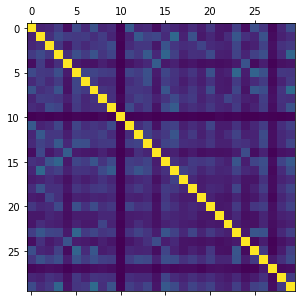

In [38]:
#topic2topic = base_matrix.T.dot(base_matrix)

from sklearn.metrics.pairwise import cosine_similarity
topic2topic = cosine_similarity(base_matrix)

print(topic2topic.shape)
#print(topic2topic)
plt.matshow(topic2topic)
#plt.colorbar()
plt.show()

In [39]:
nodes = []
count = 1
for tx,top in enumerate(topic2topic):
    node_dict = {
        'id' : count,
        'topicname' : topic_list_ext[tx]
    }
    nodes.append(node_dict)
    count += 1


graph = {
    'directed': False,
    'graph': 'semant_graph',
    'links': [],
    'nodes': nodes,
}

for ix,nodeI in enumerate(graph['nodes']):
    for jx,nodeJ in enumerate(graph['nodes']):
        if ix < jx:
            source = nodeI['id']
            target = nodeJ['id']
            weight = topic2topic[ix,jx]
            if weight > 0.15:
                link_dict = {
                    'source':source,
                    'target':target,
                    'weight':weight       
                }
                graph['links'].append(link_dict)

graph['nodes'][0]

{'id': 1,
 'topicname': 'CO2 Mieter Vermieter Mieterinnen Heizkostenzuschuss Preis Heizkosten Wohnung Energiepreise Wohngeld'}

This graph has 30 nodes and 156 links.


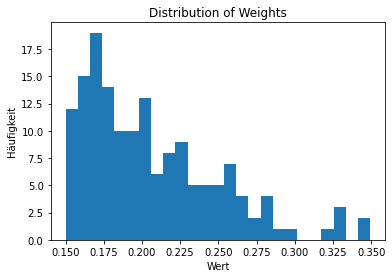

In [40]:
nn = len(graph['nodes'])
ne = len(graph['links'])
print( f"This graph has {nn} nodes and {ne} links.")

weights=[]
for link in graph['links']:
    weights.append(link['weight'])
#print(sum(weights))

plt.hist(weights, bins=25)
plt.title("Distribution of Weights")
plt.xlabel("Wert")
plt.ylabel("Häufigkeit")
plt.show()

In [45]:
properties = {
        'nodecoloring':'topicname', 
        'nodelabel': 'topicname', 
        'nodesize': 'nReden',
        #'nodelabel': 'mfic',
        "darkmode": False,
        "edgevisibility": True,
        "particles": False
       }

#htmlgraph = GraphVisualizer(graph,'name','name',True,True,True)
htmlgraph = GraphVisualizer(graph,properties)

with open (f"./semnetTopics.html", "w") as f:
    f.write(htmlgraph['graph'])

### 1.3 Temporal Evolution

In [30]:
def groupSpeechesByDate(speeches):
    groupedSpeeches = {}
    speeches.sort(key = lambda x:x['date'])
    for speech in speeches:
        top = speech['date']
        if top in groupedSpeeches:
            groupedSpeeches[top].append(speech)
        else:
            groupedSpeeches[top] = [speech]
    
    return groupedSpeeches


groupedby_date = groupSpeechesByDate(speeches)
len(groupedby_date)


#groupedby_date['2022-04-27']

34

In [51]:
groupedby_date.keys()

dict_keys(['2021-10-26', '2021-11-11', '2021-11-18', '2021-12-07', '2021-12-08', '2021-12-09', '2021-12-10', '2021-12-15', '2021-12-16', '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-26', '2022-01-27', '2022-02-16', '2022-02-17', '2022-02-18', '2022-02-27', '2022-03-16', '2022-03-17', '2022-03-18', '2022-03-22', '2022-03-23', '2022-03-24', '2022-03-25', '2022-04-06', '2022-04-07', '2022-04-08', '2022-04-27', '2022-04-28', '2022-04-29', '2022-05-11', '2022-05-12', '2022-05-13'])

In [31]:
corpus_by_date = []
for docs in groupedby_date.values():
    #print(grouped[top])
    aggregate= []
    for ele in docs:
        aggregate.append(ele['text'])
    corpus_by_date.append(' '.join(aggregate))

len(corpus_by_date) 
#corpus_by_date[0]

34

In [32]:
consider = set([x for xs in topic_words for x in xs])
#consider

In [33]:

#consider = feature_names

consider = set([x for xs in topic_words for x in xs])

def corpus_by_Features(corpus,consider):
    corpus_by = []  
    for row in tqdm.tqdm(corpus):
        doc = nlp(row)
        new_row = []
        for token in doc:
            if token.lemma_ in consider:
                new_row.append(token.lemma_)
        corpus_by.append(' '.join(new_row))
    return corpus_by 
     
corpus_by_date_features = corpus_by_Features(corpus_by_date,consider)        
len(corpus_by_date_features)

  0%|                                                                                           | 0/34 [00:00<?, ?it/s]


NameError: name 'nlp' is not defined

In [134]:
#corpus_by_date_features[1]
feature_names.index('und')
#topic_words
len(consider)

996

In [119]:
evo_vectorizer_tf = TfidfVectorizer(vocabulary=feature_names,use_idf=False, norm="l1")
#vectorizer_counts = CountVectorizer(vocabulary=feature_names)
evo_tf_matrix = evo_vectorizer_tf.fit_transform(corpus_by_date_features)
print(evo_tf_matrix.shape)
print(topic2word.shape)

topic2word_norm = normalize(topic2word, norm='l1', axis=0, copy=True, return_norm=False)

time2topic = evo_tf_matrix.dot(topic2word_norm.T)
print(time2topic.shape)
print(time2topic.sum(axis=1))

(34, 7520)
(15, 7520)
(34, 15)
[1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


No handles with labels found to put in legend.


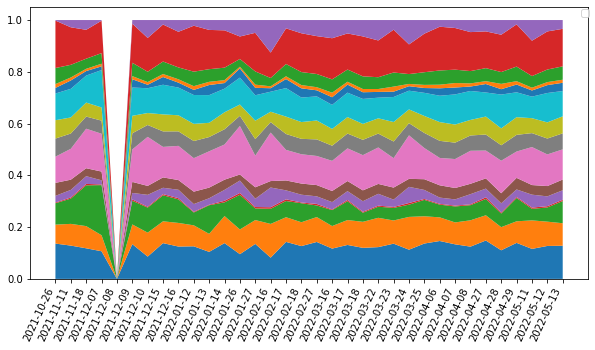

In [133]:
plt.figure(figsize=(10, 5))
#plt.plot(groupedby_date.keys(),time2topic,label = topic_list)
plt.stackplot(groupedby_date.keys(),time2topic.T)

plt.xticks(rotation=65, ha='right')
#plt.legend(loc="upper left")
plt.legend(bbox_to_anchor=(1.01, 1.01))
#locs, labels = xticks()
#xticks(locs,)
plt.show()